# Fature extraction using GAN

The code used for the GAN network is from:
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

It has been modified so that it will be compatible with the dataset. The code is based on the paper published by Ian Goodfellow on GAN.


In [1]:
import os
# Needed this so that the classifier will have deterministic and reproducible result
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
#%matplotlib inline
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.functional as F
import time

from torchinfo import summary
from pathlib import Path
from IPython.display import HTML
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
NUM_CLASSES = 5
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 128
CL_BATCH_SIZE = 32
IMAGE_DATASET_PATH = str(Path().absolute()) + "/dataset"
MANUAL_SEED= 42
NUM_EPOCHS = 100
LEARNING_RATE=0.0002
VALID_SIZE=0.1
FEATURE_MODEL_TRAINING_SIZE=0.8
CLASSIFIER_TRAINING_SIZE=0.2
# Set random seed for reproducibility
np.random.seed(MANUAL_SEED)
# Set random seed for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Random Seed:  42


In [4]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = IMAGE_SIZE[0]

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
def checkpoint(model, optimizer, filename):
    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, filename)
    
def resume(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer'])

In [6]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Define a custom dataset class for autoencoder training without labels
class ImageFolderNoLabel(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

In [8]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = None

    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif score > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0

In [9]:
train_transforms = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transforms = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [10]:
train_dataset = torchvision.datasets.ImageFolder(root='dataset/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root='dataset/test', transform=test_transforms)
gan_train_dataset = ImageFolderNoLabel(root='dataset/train', transform=train_transforms)
# gan_test_dataset = ImageFolderNoLabel(root='dataset/test', transform=train_transforms)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=CL_BATCH_SIZE,                                     
    shuffle=False,
    )
# gan_test_loader = torch.utils.data.DataLoader(
#     gan_test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
# )

## TO-DO: REFACTOR THIS TO A FUNCTION
# Split the training data to autoencoder data and classifier training data
# Autoencoder training will be 80% of the training data
# Classifier data will be 20% of the training data
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(CLASSIFIER_TRAINING_SIZE * num_train))
np.random.shuffle(indices)
gan_train_idx, cl_train_idx = indices[split:], indices[:split]
gan_train_sampler = SubsetRandomSampler(gan_train_idx)
cl_train_sampler = SubsetRandomSampler(cl_train_idx)



# gan_validation_size = int(np.floor(VALID_SIZE * len(gan_train_idx)))
cl_validation_size = int(np.floor(VALID_SIZE * len(cl_train_idx)))
# gan_validation_idx = np.random.choice(gan_train_idx, gan_validation_size, replace=False)
cl_validation_idx = np.random.choice(cl_train_idx, cl_validation_size, replace=False)
# gan_validation_sampler = SubsetRandomSampler(gan_validation_idx)
cl_validation_sampler = SubsetRandomSampler(cl_validation_idx)

# Load the training dataset for AutoEncoder
gan_train_loader = torch.utils.data.DataLoader(
    gan_train_dataset, 
    batch_size=BATCH_SIZE,
    sampler=gan_train_sampler,
)

# gan_validation_loader = torch.utils.data.DataLoader(
#     gan_train_dataset, 
#     batch_size=BATCH_SIZE,
#     sampler=gan_validation_sampler,
# )

# Load the dataset for Classifier
cl_train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=CL_BATCH_SIZE,
    sampler=cl_train_sampler,
)

# Load the validation dataset for Classifier
cl_validation_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=CL_BATCH_SIZE,
    sampler=cl_validation_sampler,
)

In [11]:
len(gan_train_loader), len(cl_train_loader), len(cl_validation_loader), len(test_loader)

(422, 422, 43, 235)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 64, 64])


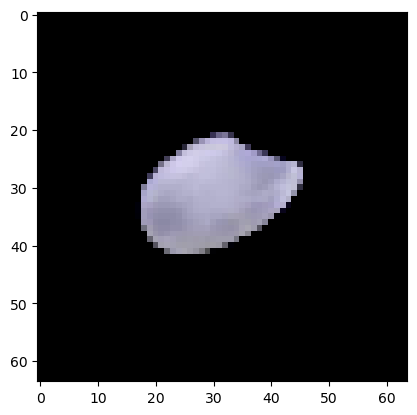

In [12]:
dataiter = iter(gan_train_loader)
images = next(dataiter)
print(images.shape)

for i, img  in enumerate(images):
  plt.imshow(img.permute(1,2,0))
  plt.show()
  # print(f"Label: {label}")
  break

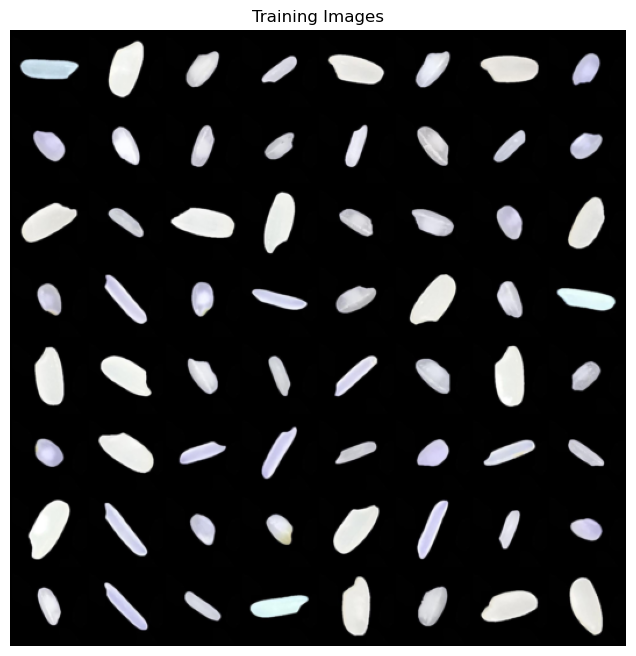

In [13]:
real_batch = next(iter(gan_train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [14]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [16]:
summary(netG, input_size=(BATCH_SIZE, nz, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [128, 3, 64, 64]          --
├─Sequential: 1-1                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [128, 512, 4, 4]          819,200
│    └─BatchNorm2d: 2-2                  [128, 512, 4, 4]          1,024
│    └─ReLU: 2-3                         [128, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [128, 256, 8, 8]          2,097,152
│    └─BatchNorm2d: 2-5                  [128, 256, 8, 8]          512
│    └─ReLU: 2-6                         [128, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [128, 128, 16, 16]        524,288
│    └─BatchNorm2d: 2-8                  [128, 128, 16, 16]        256
│    └─ReLU: 2-9                         [128, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [128, 64, 32, 32]         131,072
│    └─BatchNorm2d: 2-11                 [128, 64, 32, 32]

In [17]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [18]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [19]:
summary(netD, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [128, 1, 1, 1]            --
├─Sequential: 1-1                        [128, 1, 1, 1]            --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         3,072
│    └─LeakyReLU: 2-2                    [128, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 128, 16, 16]        131,072
│    └─BatchNorm2d: 2-4                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-5                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-6                       [128, 256, 8, 8]          524,288
│    └─BatchNorm2d: 2-7                  [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-8                    [128, 256, 8, 8]          --
│    └─Conv2d: 2-9                       [128, 512, 4, 4]          2,097,152
│    └─BatchNorm2d: 2-10                 [128, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-11                   [128, 512, 4, 4]   

In [20]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(beta1, 0.999))

In [20]:
# Training Loop
# Prior to training, the notebook should be restarted since the weights need to be reinitialized. 

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
G_losses_batch = []
D_losses_batch = []
iters = 0
patience = 5  # Number of epochs to wait for improvement
early_stopping = EarlyStopping(patience=patience, verbose=True)

print("Starting Training Loop...")
# For each epoch
for epoch in range(NUM_EPOCHS):
    running_loss_D = 0.0
    running_loss_G = 0.0
    
    # For each batch in the dataloader
    for i, data in enumerate(gan_train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.7f\tLoss_G: %.7f\tD(x): %.7f\tD(G(z)): %.7f / %.7f'
                  % (epoch, NUM_EPOCHS, i, len(gan_train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        running_loss_D += errD.item()
        running_loss_G += errG.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    
    avg_loss_D = running_loss_D / len(gan_train_loader.dataset)
    avg_loss_G = running_loss_G / len(gan_train_loader.dataset)

    D_losses_batch.append(avg_loss_D)
    G_losses_batch.append(avg_loss_G)

    print(f'[{epoch}/{NUM_EPOCHS}] Avg_Loss_D: {avg_loss_D:.4f} Avg_Loss_G: {avg_loss_G:.4f}')

    # Discriminator Loss
    early_stopping(avg_loss_D, epoch)

    checkpoint(netD, optimizerD, f'DCGAN_discriminator_{epoch}.pth')
    checkpoint(netG, optimizerG, f'DC_GAN_generator_{epoch}.pth')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
    
    # Optionally, save the best model
    if early_stopping.best_epoch == epoch:
        print("BEST DISCRIMINATOR LOSS: ", avg_loss_D)
        checkpoint(netG, optimizerG, 'best_generator.pth')
        checkpoint(netD, optimizerD, 'best_discriminator.pth')
    
    print("----------------------------------------------------------")


Starting Training Loop...
[0/100][0/422]	Loss_D: 1.6974496	Loss_G: 5.2837315	D(x): 0.7020853	D(G(z)): 0.6465038 / 0.0096869
[0/100][50/422]	Loss_D: 0.0000045	Loss_G: 32.0154724	D(x): 0.9999955	D(G(z)): 0.0000000 / 0.0000000
[0/100][100/422]	Loss_D: 0.3479901	Loss_G: 3.5096002	D(x): 0.7555059	D(G(z)): 0.0423928 / 0.0519645
[0/100][150/422]	Loss_D: 0.3897630	Loss_G: 3.1955132	D(x): 0.7779443	D(G(z)): 0.0873661 / 0.0732789
[0/100][200/422]	Loss_D: 0.1708755	Loss_G: 4.7245703	D(x): 0.9541965	D(G(z)): 0.1112204 / 0.0121099
[0/100][250/422]	Loss_D: 0.7634470	Loss_G: 4.7050891	D(x): 0.5601159	D(G(z)): 0.0473926 / 0.0283949
[0/100][300/422]	Loss_D: 0.2049293	Loss_G: 3.8150899	D(x): 0.9292548	D(G(z)): 0.1164530 / 0.0310332
[0/100][350/422]	Loss_D: 0.0967245	Loss_G: 3.8331721	D(x): 0.9451194	D(G(z)): 0.0366964 / 0.0280960
[0/100][400/422]	Loss_D: 0.2145280	Loss_G: 3.1721926	D(x): 0.8648816	D(G(z)): 0.0574936 / 0.0582683
[0/100] Avg_Loss_D: 0.0037 Avg_Loss_G: 0.0433
BEST DISCRIMINATOR LOSS:  0.00

## Plotting the losses over iterations and epochs

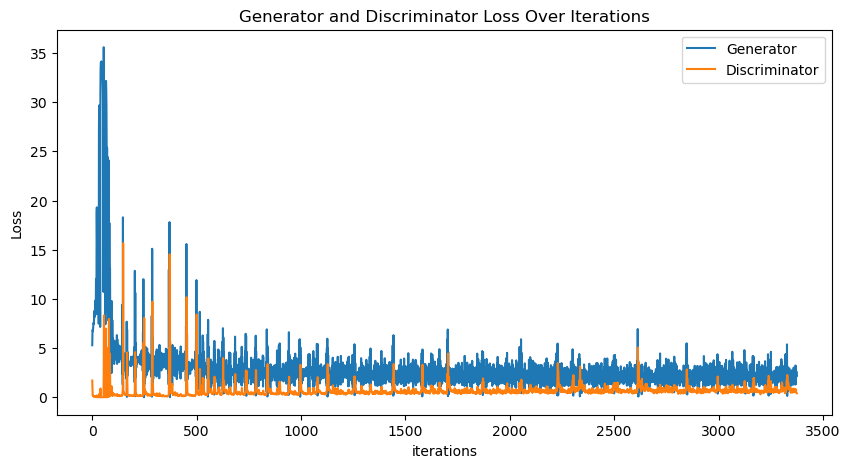

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss Over Iterations")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

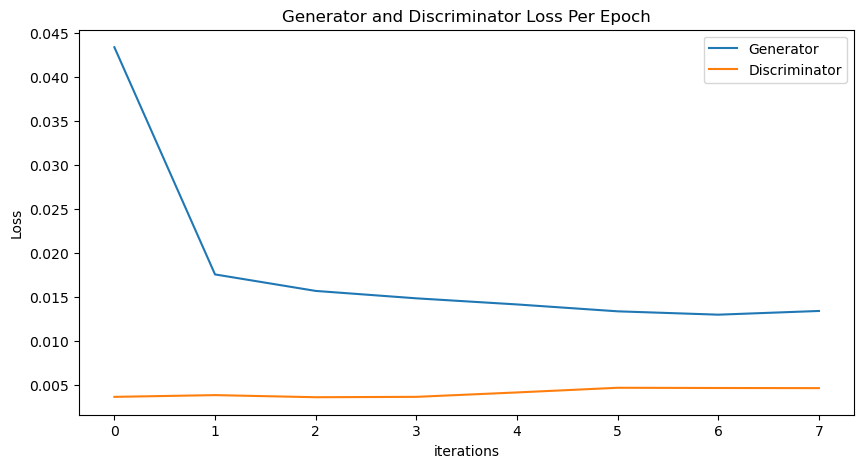

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss Per Epoch")
plt.plot(G_losses_batch,label="Generator")
plt.plot(D_losses_batch,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Visualizing the Generated Images per Epoch

MovieWriter imagemagick unavailable; using Pillow instead.


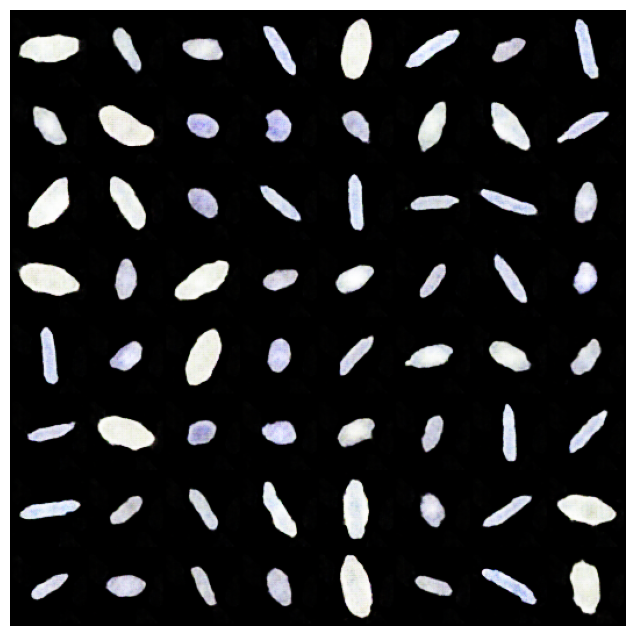

In [29]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('generation.gif', writer='imagemagick', fps=1)

HTML(ani.to_jshtml())

<img src="generation.gif" width="750" align="center">

## Classifier with Features extracted by the Discriminator

### Load and Freeze the pretrained model

Load the best discriminator model and freeze the weights so that it won't be updated when training the classifier

In [21]:
def test(model, test_loader):
  model.eval()
  per_batch_accuracy = {}
  per_batch_loss = {}
  classes = list(train_dataset.class_to_idx.keys())
  criterion = nn.CrossEntropyLoss()

  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(NUM_CLASSES)]
      n_class_samples = [0 for i in range(NUM_CLASSES)]
      val_loss = 0.0
      for i, (images, labels) in enumerate(test_loader):
          images = images.to(device)
          labels = labels.to(device)
          
          outputs = model(images)
  #         max returns (value ,index)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          
          per_batch_accuracy[i] = (predicted == labels).sum().item() / labels.size(0)
          per_batch_loss[i] = loss.item()
          
          for i in range(labels.size(dim=0)):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1

      acc = 100.0 * n_correct / n_samples
      print(f'Accuracy of the network: {acc} %')
      
      for i in range(NUM_CLASSES):
          acc = 100.0 * n_class_correct[i] / n_class_samples[i]
          print(f'Accuracy of {classes[i]}: {acc} %')
          
  return per_batch_accuracy, per_batch_loss

In [22]:
def train(model, train_loader, valid_loader, filename):
  total_step = len(train_loader)
  start = time.perf_counter()
  best_accuracy = -1
  start_epoch = 0
  start_step = 0
  early_stop_thresh = 5
  val_loss_per_epoch = {}
  train_loss_per_epoch = {}
  train_accuracy_per_epoch = {}
  val_accuracy_per_epoch = {}
  total_step = len(train_loader)
  classes = list(train_dataset.class_to_idx.keys())
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  

  for epoch in range(start_epoch, NUM_EPOCHS):
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(NUM_CLASSES)]
      n_class_samples = [0 for i in range(NUM_CLASSES)]
      model.train()
      start_epoch_timer = time.perf_counter()
      train_loss = 0.0
      
      for i, (images, labels) in enumerate(train_loader):
          if i < start_step:
              continue
          
          if i == start_step:
              print(f"Starting the training process at {i} step, epoch {epoch + 1}...")
          
          # Move tensors to the configured device
          images = images.to(device)
          labels = labels.to(device)
        #   print(images.shape, labels.shape)
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          
          for y in range(labels.size(dim=0)):
              label = labels[y]
              pred = predicted[y]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          if (i + 1) % 100 == 0:
              end_batch_timer = time.perf_counter()
  #             checkpoint(model, optimizer, f"VGG-epoch-{epoch}-{i}.pth")
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Seconds per 600 images: {}'.format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(), (end_batch_timer - start_epoch_timer)))
      train_loss /= len(train_loader.dataset)
      
      if start_step <= 0:
          acc = 100.0 * n_correct / n_samples
          end_epoch_timer = time.perf_counter()
          train_accuracy_per_epoch[epoch] = acc
        #   checkpoint(model, optimizer, f"AECNN-epoch-{epoch}-full.pth")
          print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Accuracy of the network: {acc} %, Epoch Training Time: {end_epoch_timer - start_epoch_timer}')

          for i in range(NUM_CLASSES):
              acc = 100.0 * n_class_correct[i] / n_class_samples[i]
              print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Accuracy of {classes[i]} for training: {acc} %. Train Loss {train_loss}')
          print("------------------------------------------------------------")
              
  # Validation
  # No validation at the moment.
      model.eval()
      with torch.no_grad():
          print(f"VALIDATING THE MODEL FOR EPOCH {epoch + 1}")
          correct = 0
          total = 0
          val_loss = 0.0
          for images, labels in valid_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              del images, labels, outputs
          val_loss /= len(valid_loader.dataset)
          
          acc = correct / total
          print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * acc)) 
          print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss}, Val Loss: {val_loss}. TIME: {end_epoch_timer - start_epoch_timer} seconds")
          
          train_loss_per_epoch[epoch] = train_loss
          val_loss_per_epoch[epoch] = val_loss
          val_accuracy_per_epoch[epoch] = acc
          # Early stopping
          if acc > best_accuracy:
              print(f"Best accuracy changed: {acc:7f}")
              best_accuracy = acc
              best_epoch = epoch
              checkpoint(model, optimizer, f"{filename}_best_model.pth")
          elif epoch - best_epoch > early_stop_thresh:
              print("Early stopped training at epoch %d" % epoch)
              break  # terminate the training loop
          print("------------------------------------------------------------")
  end = time.perf_counter()
  print(f'{end - start} seconds')
  return val_loss_per_epoch, train_loss_per_epoch, train_accuracy_per_epoch, val_accuracy_per_epoch, optimizer

In [23]:
def graph_train_valid(train_loss_per_epoch, val_loss_per_epoch, title='Training and Validation Loss', label1="Training Loss", label2="Validation Loss", location="upper right"):
  plt.plot(list(train_loss_per_epoch.keys()), list(train_loss_per_epoch.values()), label=label1)
  plt.plot(list(val_loss_per_epoch.keys()), list(val_loss_per_epoch.values()), label=label2)
  plt.legend(loc=location)
  plt.title(title)
  plt.show()

In [24]:
def update_accuracy(t):
  for key in t:
    t[key] = t[key] * 100

In [25]:
def graph_loss(per_batch_loss, title="Per Batch Loss"):
  plt.plot(list(per_batch_loss.keys()), list(per_batch_loss.values()), label='Training Loss')
  plt.title(title)
  plt.show()

In [26]:
resume(netD, optimizerD, f"best_discriminator.pth")

In [27]:
for param in netD.parameters():
  param.requires_grad = False

In [28]:
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 64, 64])
422


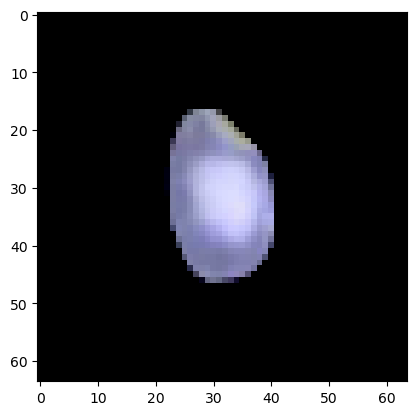

In [29]:
dataiter = iter(cl_train_loader)
images, label = next(dataiter)
print(images.shape)
print(len(cl_train_loader))
for i, img  in enumerate(images):
  plt.imshow(img.permute(1,2,0))
  plt.show()
  # print(f"Label: {label}")
  break

In [30]:
class Classifier(nn.Module):
    def __init__(self, num_classes, netD):
        super(Classifier, self).__init__()
        self.discriminator = nn.Sequential(*list(netD.main.children())[:-2])
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(CL_BATCH_SIZE * 64, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        temp = self.discriminator(x)
        temp2 = self.pool(temp)
        temp3 = temp2.view(-1, CL_BATCH_SIZE * 64)
        temp4 = torch.flatten(temp3, 1)
        # print(BATCH_SIZE * 512)
        # print("TEMP: ", temp.shape, "TEMP 2: ", temp2.shape, "Temp 3", temp3.shape, "TEMP 4", temp4.shape)
        x = F.relu(self.fc1(temp4))
        x = self.fc2(x)
        return x

In [31]:
classifier = Classifier(5, netD)

In [32]:
summary(classifier, input_size=(CL_BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [32, 5]                   --
├─Sequential: 1-1                        [32, 512, 4, 4]           --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          (3,072)
│    └─LeakyReLU: 2-2                    [32, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [32, 128, 16, 16]         (131,072)
│    └─BatchNorm2d: 2-4                  [32, 128, 16, 16]         (256)
│    └─LeakyReLU: 2-5                    [32, 128, 16, 16]         --
│    └─Conv2d: 2-6                       [32, 256, 8, 8]           (524,288)
│    └─BatchNorm2d: 2-7                  [32, 256, 8, 8]           (512)
│    └─LeakyReLU: 2-8                    [32, 256, 8, 8]           --
│    └─Conv2d: 2-9                       [32, 512, 4, 4]           (2,097,152)
│    └─BatchNorm2d: 2-10                 [32, 512, 4, 4]           (1,024)
│    └─LeakyReLU: 2-11                   [32, 

In [33]:
history = train(classifier, cl_train_loader, cl_validation_loader, "GANCNN")

Starting the training process at 0 step, epoch 1...
Epoch [1/100], Step [100/422], Loss: 0.2767, Seconds per 600 images: 5.391250799999998
Epoch [1/100], Step [200/422], Loss: 0.2107, Seconds per 600 images: 10.595753399999996
Epoch [1/100], Step [300/422], Loss: 0.1916, Seconds per 600 images: 15.663793699999996
Epoch [1/100], Step [400/422], Loss: 0.1496, Seconds per 600 images: 20.719956999999997
Epoch [1/100]: Accuracy of the network: 92.65185185185184 %, Epoch Training Time: 21.8207596
Epoch [1/100]: Accuracy of Arborio for training: 88.54442344045368 %. Train Loss 0.0019269733014482039
Epoch [1/100]: Accuracy of Basmati for training: 94.06968124536694 %. Train Loss 0.0019269733014482039
Epoch [1/100]: Accuracy of Ipsala for training: 98.68947943210776 %. Train Loss 0.0019269733014482039
Epoch [1/100]: Accuracy of Jasmine for training: 87.52286864251738 %. Train Loss 0.0019269733014482039
Epoch [1/100]: Accuracy of Karacadag for training: 94.3220022413149 %. Train Loss 0.001926973

### Testing the classifier with the test data

Load the best classifier model

In [34]:
resume(classifier, history[4], f"GANCNN_best_model.pth")

In [35]:
test_history_1000 = test(classifier, test_loader)

Accuracy of the network: 98.05333333333333 %
Accuracy of Arborio: 99.66666666666667 %
Accuracy of Basmati: 97.53333333333333 %
Accuracy of Ipsala: 99.8 %
Accuracy of Jasmine: 93.6 %
Accuracy of Karacadag: 99.66666666666667 %


### Visualization of the performance of the CNN with Discriminator

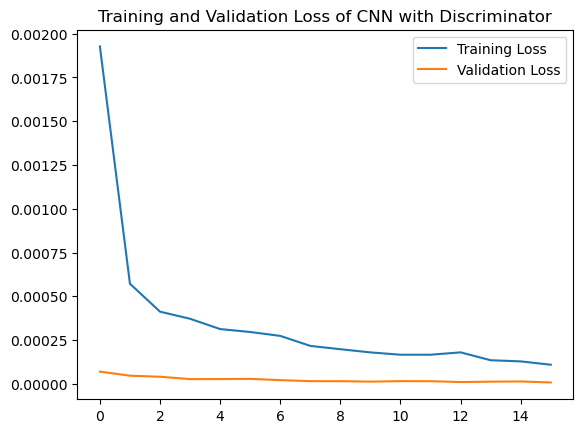

In [36]:
graph_train_valid(history[1], history[0], title="Training and Validation Loss of CNN with Discriminator")

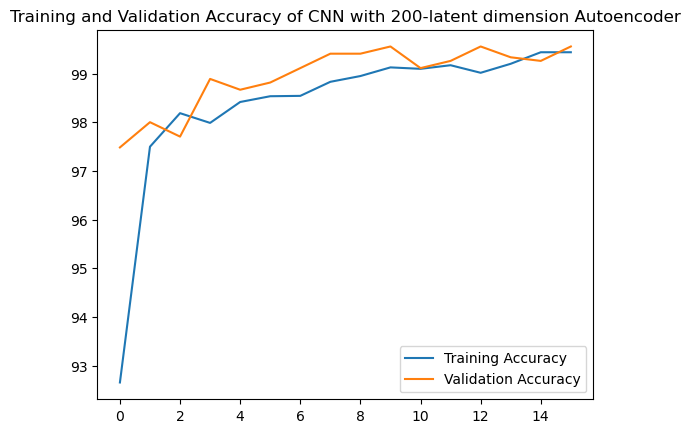

In [37]:
# a = [x * 100 for x in list(train_history[3].values())]
temp = history[3]
update_accuracy(temp)
graph_train_valid(history[2], temp, title="Training and Validation Accuracy of CNN with 200-latent dimension Autoencoder", label1="Training Accuracy", label2="Validation Accuracy", location="lower right")

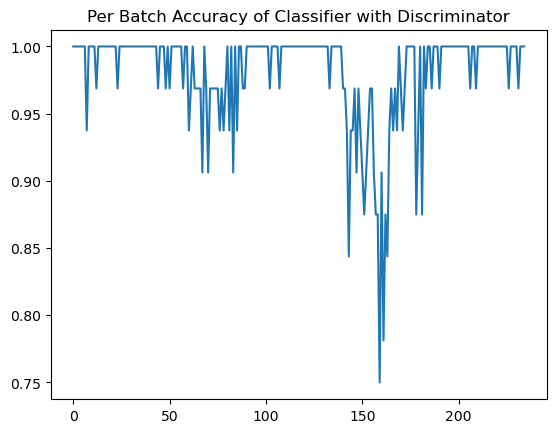

In [38]:
graph_loss(test_history_1000[0], "Per Batch Accuracy of Classifier with Discriminator")

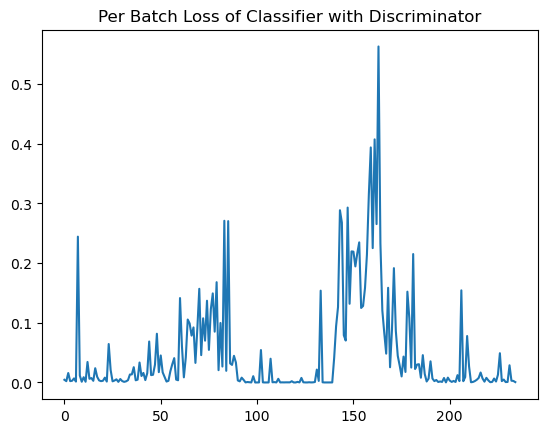

In [39]:
graph_loss(test_history_1000[1], "Per Batch Loss of Classifier with Discriminator")